# Lesson: Single Model CRUD

## Introduction

A **model** is class that holds data from a row or a record. Attribute names and column/field names should be relatively similar. A model may be represented as a `@dataclass`, though it doesn't necessarily need to be. Models should not be complicated.

Our models translate back and forth with SQL CRUD operations. Models are inserted (created), updated, deleted, and use queries to read. In an ORM (object-relational mapping) package, queries are auto-generated and auto-map to objects (models). When we explicitly write SQL queries, our objects/models are also mapped.

We use classes that manage our database connections, cursors, and queries for us. Say we have a `Customer` model. Common database management class names are:

- `CustomerRepository`: CRUD, no validation
- `CustomerDataStore`: CRUD, no validation
- `CustomerService`: CRUD, requires validation
- `CustomerManager`: CRUD, requires validation

### Learning Outcomes

When you've finished this lesson and its exercises, you should be able to:

- Use a `DatabaseContext`.
- Fetch zero to many models with a repository.
- Insert and update models with a repository.
- Delete a database record with criteria in a repository.

## Repositories in Applications vs Data Pipelines (ETL)

A **pattern**, or [software design pattern](https://en.wikipedia.org/wiki/Software_design_pattern), is a repeatable strategy that's been shown to be effective in professional software development. Patterns vary in size from a method or two to many types working together across layers. Patterns have names like _facade_, _object pool_, _command_, and _reactor_. When two developers who understand a pattern use its name, they're able to omit many details and discuss a solution to a problem at a higher level. It's easier to communicate because complex information is delivered with a single name. Patterns are a form of mental chunking.

In its simplest form, the [repository pattern](https://martinfowler.com/eaaCatalog/repository.html) is a single class that acts as a collection of models. It has methods to add a model, update a model, delete a model, and find models that match some criteria. Under the hood, the repository stores and retrieves data from some data source. It could be a file, a database, or a network API. Models can even be stored in memory. A repository never reveals the details. Ideally, the data source is unimportant. What is important is that developers have a reliable and consistent way to persist and fetch data.

The repository pattern is common in Python applications. It can also use names like `DataStore`, `Store`, `DAO` (Data access object), `Manager`, and `Provider`. It separates concerns and DRYs up our code.

In our data pipelines, the repository is not as common, though it's becoming more so. With tools like [Pandas](https://pandas.pydata.org/) and [PySpark](https://spark.apache.org/docs/latest/api/python/index.html), we also separate concerns. We don't want to extract-&gt;transform-&gt;load all in one file or all in one class. We want to use the _single responsibility principle_ to break code down into methods and classes. Your teams "single responsibility" may be different.

## `bowls`

We'll use the `bowls` schema.

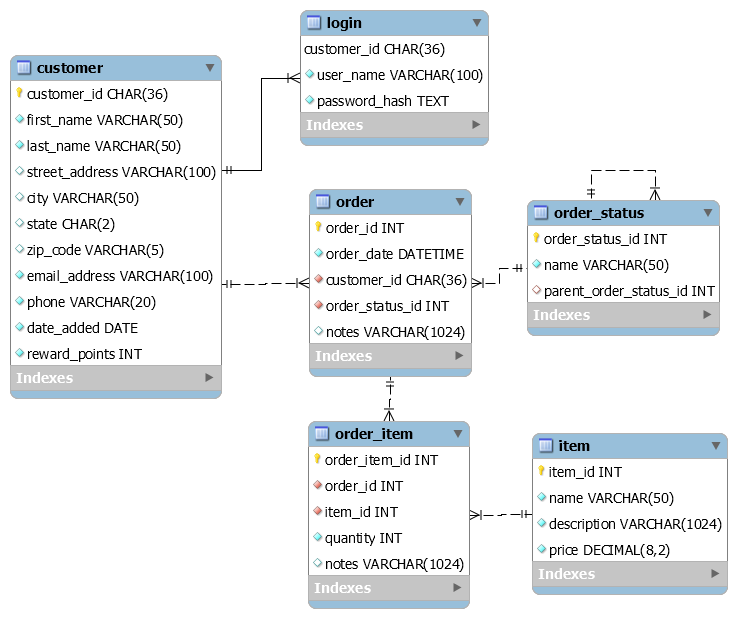

## Code-Along

### Customer Model

In our `bowls` schema, our `customer` table maps to our `Customer` model.

In [35]:
from dataclasses import dataclass
from datetime import date


@dataclass
class Customer:
    customer_id: str
    first_name: str
    last_name: str
    street_address: str
    city: str
    state: str
    zip_code: str
    email_address: str
    phone: str
    date_added: date
    reward_points: int = 0

    def to_tuple(self):
        return (
            self.customer_id,
            self.first_name,
            self.last_name,
            self.street_address,
            self.city,
            self.state,
            self.zip_code,
            self.email_address,
            self.phone,
            self.date_added,
            self.reward_points,
        )

### DatabaseContext

Here's our foundational class that attaches a class to a connection. Under the hood, we use a cursor to fetch rows, insert rows, and update/delete rows.

In [36]:
class DatabaseContext:
    def __init__(self, connection):
        self._connection = connection

    def find(self, query, params=None) -> list[tuple]:
        with self._connection.cursor() as cursor:
            cursor.execute(query, params)
            return cursor.fetchall()

    def find_one(self, query, params=None) -> tuple:
        with self._connection.cursor() as cursor:
            cursor.execute(query, params)
            return cursor.fetchone()

    def insert(self, query, params=None):
        with self._connection.cursor() as cursor:
            cursor.execute(query, params)
            self._connection.commit()
            return cursor.lastrowid

    def update(self, query, params=None) -> int:
        with self._connection.cursor() as cursor:
            cursor.execute(query, params)
            self._connection.commit()
            return cursor.rowcount

    def close(self):
        if self._connection.is_connected():
            self._connection.close()

### CustomerRepository

Next, our repository builds off that foundation.

Our `find_all` and `find_by_last_name_begins_with` methods use `DatabaseContext.find` to send a query and parameters. The `find_by_id` and `find_by_email` methods use `DatabaseContext.find_one` to send a query and parameters.

The `insert` method builds off `DatabaseContext.insert`. The `update` and `delete_by_email` methods use `DatabaseContext.update`.

Our `with` statement uses the special methods `__enter__` and `__exit__`.

In [37]:
import uuid

class CustomerRepository:
    SELECT = """
        SELECT
            customer_id,
            first_name,
            last_name,
            street_address,
            city,
            state,
            zip_code,
            email_address,
            phone,
            date_added,
            reward_points
        FROM customer
    """

    def __init__(self, connection):
        self.context = DatabaseContext(connection)

    def find_all(self, limit=25):
        query = f"{self.SELECT} LIMIT %s;"
        return [Customer(*record) for record in self.context.find(query, (limit,))]

    def find_by_last_name_begins_with(self, last_name_prefix):
        query = f"{self.SELECT} WHERE last_name LIKE %s;"
        return [
            Customer(*record)
            for record in self.context.find(query, (f"{last_name_prefix}%",))
        ]

    def find_by_id(self, customer_id):
        query = f"{self.SELECT} WHERE customer_id = %s;"
        record = self.context.find_one(query, (customer_id,))
        if record:
            return Customer(*record)
        return None

    def find_by_email(self, email):
        query = f"{self.SELECT} WHERE email_address = %s;"
        record = self.context.find_one(query, (email,))
        if record:
            return Customer(*record)
        return None

    def insert(self, customer):
        query = """
            INSERT INTO customer (
                customer_id,
                first_name,
                last_name,
                street_address,
                city,
                state,
                zip_code,
                email_address,
                phone,
                date_added,
                reward_points
            ) VALUES (
                %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s
            );"""
        
        customer.customer_id = str(uuid.uuid4())
        params = customer.to_tuple()
        return self.context.insert(query, params)

    def update(self, customer):
        query = """
            UPDATE customer SET
                first_name = %s,
                last_name = %s,
                street_address = %s,
                city = %s,
                state = %s,
                zip_code = %s,
                email_address = %s,
                phone = %s,
                date_added = %s,
                reward_points = %s
            WHERE customer_id = %s;"""
        params = customer.to_tuple()
        return self.context.update(query, params[1:] + params[0:1])

    def delete_by_email(self, email):
        query = "DELETE FROM customer WHERE email_address = %s;"
        return self.context.update(query, (email,))

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.context.close()

### MySQL Connection

Our `DatabaseContext` is database vendor agnostic. It could be MySQL, PostgreSQL, Oracle, MS SQL Server, and even SQLite. 

For now, we'll choose MySQL. We use Dynaconf for configuration. Check your `single-model-crud/.env` file. Set your local MySQL credentials there.

In [38]:
import mysql.connector
from dynaconf import Dynaconf

def build_connection():
    settings = Dynaconf(envvar_prefix="DB", load_dotenv=True)
    return mysql.connector.connect(
        host=settings.HOST,
        port=settings.PORT,
        user=settings.USER,
        password=settings.PASSWORD,
        database=settings.DATABASE,
    )

### Find

Our `DataContext.find` method is flexible. It can use any SQL query and any parameters. With our `CustomerRepository`, we map a `list[Customer]` to a tuple.

In [ ]:
with CustomerRepository(build_connection()) as repository:
    # Find all customers.
    # Default limit is 25, though we can specify a different limit.
    print("\nCustomers")
    for customer in repository.find_all(limit=5):
        print(f"{customer.first_name} {customer.last_name}")
        
    print("\nCustomer with last name starting with 'Gr'")
    for customer in repository.find_by_last_name_begins_with("Gr"):
        print(f"{customer.first_name} {customer.last_name}")

### Find One

Find a single record. A customer ID is unique. An email address is unique as well. We map a `Customer` to a tuple.

In [ ]:
with CustomerRepository(build_connection()) as repository:
    customer = repository.find_by_id("433afc20-3b7f-406d-ad9f-6f31b9effb99")
    if customer:
        print(f"Customer found: {customer.first_name} {customer.last_name} {customer.customer_id}")
    else:
        print("Customer not found")

    id = "4x3xfx2x-3x7x-4x6x-ax9x-6x3xbxexfx9x"
    customer = repository.find_by_id(id)
    if customer:
        print(f"Customer found: {customer.first_name} {customer.last_name} {customer.customer_id}")
    else:
        print(f"Customer not found with id {id}")

    customer = repository.find_by_email("tgroven1@ft.com")
    if customer:
        print(f"Customer found: {customer.first_name} {customer.last_name} {customer.email_address}")
    else:
        print("Customer not found")

    email = "example@example.com"
    customer = repository.find_by_email(email)
    if customer:
        print(f"Customer found: {customer.first_name} {customer.last_name} {customer.email_address}")
    else:
        print(f"Customer not found with email {email}")

### Insert

We create a `Customer` object, convert it to a tuple, and then use our query and tuple parameters to insert into the database. Our `customer` table doesn't have an auto-incremented id, so we'll use the [uuid](https://docs.python.org/3/library/uuid.html) module to generate it for us.

MySQL generates UUID()s either with a trigger or with a query, no default values, so we'll use `uuid`.

In [41]:
customer = Customer(
    str(uuid.uuid4()),
    "Amata",
    "Huburn",
    "9 Golden Leaf Terrace",
    "Roanoke",
    "VA",
    "24020",
    "ahuburn4@google.nl",
    "205-105-6418",
    date(2021, 7, 9))

with CustomerRepository(build_connection()) as repository:
    # Since our `return cursor.lastrowid` doesn't return the lastrowid, 
    # the id isn't auto-incremented,
    # our insert doesn't return anything.
    # It's a success if the insert doesn't raise an exception.
    repository.insert(customer)

### Update

It's common to read from a database, a `Customer`, update attributes, and then send updates to the database.

In [ ]:
with CustomerRepository(build_connection()) as repository:
    customer = repository.find_by_email("ahuburn4@google.nl")
    if customer:
        customer.street_address = "50650 Manley Place"
        customer.city = "Lansing"
        customer.state = "MI"
        customer.zip_code = "48919"
        customer.phone = "517-563-7755"
        customer.reward_points = 100
        result = repository.update(customer)
        print("Success!" if result == 1 else "Failed :(")
    else:
        print("Customer not found")

### Delete

It's not common to delete from a production database. It's much more common to do a "soft" delete. When we have a status column or field, we set that status to "deleted". 

An alternative is table logging. Our inserts, updates, and deletes get logged for a specific table.

`customer_log`

| status | customer_id | first_name | last_name | street_address        | city    | state |
| ------ | ----------- | ---------- | --------- | --------------------- | ------- | ----- |
| insert | 19aee9f0... | Amata      | Huburn    | 9 Golden Leaf Terrace | Roanoke | VA    |
| update | 19aee9f0... | Amata      | Huburn    | 50650 Manley Place    | Lansing | MI    |
| delete | 19aee9f0... | Amata      | Huburn    | 50650 Manley Place    | Lansing | MI    |

<p><hr></p>

In data engineering, our **load** in ETL gets stored in a data warehouse. It's much more common to delete records from a data warehouse, especially if we need to adjust our schema.

For now, we'll explicitly delete records from the `bowls.customer` table.

In [ ]:
with CustomerRepository(build_connection()) as repository:
    result = repository.delete_by_email("ahuburn4@google.nl")
    print("Success!" if result == 1 else "Failed :(")
    result = repository.delete_by_email("ahuburn4@google.nl")
    print("Success!" if result == 1 else "Failed :(")

## SQL Exceptions

It's inevitable that a database will fail.

**Causes**

- bad credentials.
- can't connect
- integrity error: a parent row is deleted and causes a foreign key error in the child, a child insert goes before the parent insert and fails.
- unique constraints
- invalid values: too long, wrong data type
- bad SQL grammar

We don't to handle these exceptions in our `DatabaseContext` or `CustomerRepository` (except for SQL grammar).

With integrity errors, unique constraints, and invalid values, we want to validate _before_ anything happens. Validation is important. Validation rules are often described as "business rules", "business logic", or "domain logic".

With bad credentials or no network connection, we handle them globally and then log the exception. There's no graceful way to manage the connection.

In [ ]:
customer = Customer(
    str(uuid.uuid4()),
    "Amata",
    "Huburn",
    "9 Golden Leaf Terrace",
    "Roanoke",
    "VA",
    "24020",
    "ahuburn4@google.nl",
    "205-105-6418",
    date(2021, 7, 9),
)

with CustomerRepository(build_connection()) as repository:
    repository.insert(customer)
    try:
        repository.insert(customer)
    except mysql.connector.IntegrityError as e:
        print(e)


But a better solution would be to validate first.

In [ ]:
customer_email = "ahuburn4@google.nl"
customer = Customer(
    str(uuid.uuid4()),
    "Amata",
    "Huburn",
    "9 Golden Leaf Terrace",
    "Roanoke",
    "VA",
    "24020",
    customer_email,
    "205-105-6418",
    date(2021, 7, 9),
)

with CustomerRepository(build_connection()) as repository:
    c = repository.find_by_email(customer_email)
    if c:
        # various alternatives:
        print("Customer already exists")
        pass # could pass

        # raise ValueError("Customer already exists") # could raise an exception

        # customer.customer_id = c.customer_id
        # result = repository.update(customer) # could update
    else:
        repository.insert(customer)

With integrity errors, parent/child, we can decide if we want to delete everything or be sensitive to rejecting/ignoring the parent.

```py
class CustomerRepository:
    
    # <snip...>

    def delete_by_email(self, email):
        # delete order_items
        query = """
        DELETE oi
        FROM order_item oi
        INNER JOIN `order` o on oi.order_id = o.order_id
        INNER JOIN customer c on o.customer_id = c.customer_id
        WHERE c.email_address = %s;
        """
        self.context.update(query, (email,))

        # delete orders
        query = """
        DELETE o
        FROM `order` o
        INNER JOIN customer c on o.customer_id = c.customer_id
        WHERE c.email_address = %s;
        """
        self.context.update(query, (email,))

        # delete logins
        query = """
        DELETE login
        FROM login
        INNER JOIN customer c on login.customer_id = c.customer_id
        WHERE c.email_address = %s;
        """
        self.context.update(query, (email,))

        query = "DELETE FROM customer WHERE email_address = %s;"
        return self.context.update(query, (email,))

    # <snip...>
```

It's also okay to just handle the `IntegrityError` in our validation logic.